# Introduction to Segment Anything Model (SAM)

The **Segment Anything Model (SAM)** is a powerful **promptable segmentation system**.  
Its main strength lies in its ability to **segment objects in any image or video**.

Unlike traditional image segmentation models (which are trained for specific object categories like “person,” “cat,” or “car”), SAM is a **general-purpose model**.  
It can generate object masks based on **different types of prompts**, including:
- Points (e.g., "for this pixel, what is the segmentation for this object"),
- Bounding boxes (e.g., "segment whatever is inside this box"),
- Or a full image

---

## Why SAM Matters in Robotics

SAM’s generalization power enables robots to **see** their environment. Robots need precise visual perception to safely interact with their surroundings.


While SAM is great at segmentation, it **cannot locate specific objects**. It can’t tell you which mask belongs to a “phone” or a “cup.”  
To build robots that follow commands like:
> “Pick up the phone”  
we need models that can **visually locate an object with language** — these are called **Vision-Language Models (VLMs)**.

A **VLM** interprets an English command, locates the corresponding object in an image, and returns a **bounding box** around that object.  
Then, we can use **SAM**, guided by this bounding box, to produce a **precise segmentation mask** of the object.

*Note: Noteably, Grounded SAM can segment objects based on human prompts and return the segmentation mask with a semantic label! Along with VLMs, more general object detection models (like YOLO) can also be used to produce bounding boxes (and can be more efficient/accurate, making them better for certain settings). We won't be exploring these models in this notebook, but feel free to check them out on your own time!*

---

# Notebook Objectives

In this notebook, we’ll explore how SAM and a VLM can work **together** to achieve language-driven segmentation.

### Step 1: Run SAM on an image
We’ll start by running SAM directly on an image.  
You’ll see that SAM can segment all visible objects — but it doesn’t know what any of them are.

---

### Step 2: Use a Vision-Language Model (VLM)
Next, we’ll introduce a **VLM** that can process both **images and text prompts**.  
We’ll ask it something like:
> “Find the phone in this image.”

The VLM will then **generate a bounding box** around the phone and return the dimensions of the bounding box.

---

### Step 3: Combine SAM and the VLM
Finally, we’ll use the **bounding box from the VLM as a prompt for SAM**.  
SAM will then return a **high-precision segmentation mask** for just the phone!

---

# Learning Goal

By the end of this notebook, you’ll understand:
- What SAM is and how it performs segmentation.
- Why SAM alone isn’t enough for language-based commands.
- How VLMs can identify objects using text prompts.
- How to use **VLM → bounding box → SAM** for natural-language-driven segmentation.

---

## Note:
Loading SAM and a VLM would be too costly for Deepnote so we (the TAs) have run SAM and the VLM offline. All functions in this niotebook load the returned output from running SAM and a VLM.


# Step 1: Load an Image


In [ ]:
import time
from io import BytesIO

import matplotlib.pyplot as plt
import requests
from PIL import Image

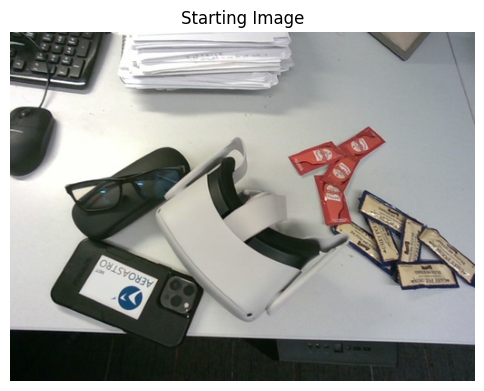

In [ ]:
def load_raw_image() -> Image.Image:
    try:
        raw_url = "https://raw.githubusercontent.com/escharf320/6.4210_pset8/master/raw_img.png"
        response = requests.get(raw_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        return img
    except Exception as e:
        print(f"Error loading image: {e}")
        return None


def display_image(img: Image.Image, title: str = None):
    if img is None:
        print("Failed, no image to display.")
        return

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


img = load_raw_image()
display_image(img, title="Starting Image")

# Step 2: Run SAM on the Whole Image

Now, let’s apply **SAM** directly to the image *without any prompt*.  
SAM will try to segment everything it sees — generating multiple object masks.

*Note:* The TAs have already run SAM offline for you, (you're welcome). The function below returns the image from running SAM. Generally running SAM locally takes more time.

Running SAM on input image ...
No prompt passed through. Generating a mask for the full image


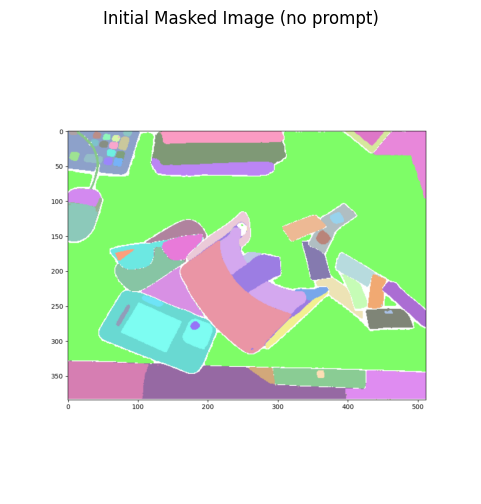

In [ ]:
def run_sam_no_prompt() -> Image.Image:
    try:
        print("Running SAM on input image ...")
        print("No prompt passed through. Generating a mask for the full image")
        time.sleep(1)
        raw_url = "https://raw.githubusercontent.com/escharf320/6.4210_pset8/master/output_segmentation_masks.png"
        response = requests.get(raw_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        return img
    except Exception as e:
        print(f"Error loading image: {e}")
        return None


def display_image(img: Image.Image, title: str = None):
    if img is None:
        print("Failed, no image to display.")
        return

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


img = run_sam_no_prompt()
display_image(img, title="Initial Masked Image (no prompt)")

# Step 3: The Problem — SAM Can’t Understand Language

If we asked SAM to "find the phone," it wouldn’t know what that means.  
SAM can segment *all* objects, but it doesn’t know their **semantic meaning**. Futhermore, looking at the iPhone we see that it is oversegmented. The cameras and sticker have their own segmentation mask. We would like one segmentation mask for the iPhone.

This is a fundamental limitation in pure vision models.

Next, we’ll see how a **Vision-Language Model (VLM)** helps solve this problem.



# Step 4: Use a Vision-Language Model (VLM) to Find the Object

Here, we’ll use a **VLM (like GPT of Grounding DINO)** to process:
- the **image**, and  
- a **text prompt** like “find the phone.”

The VLM will interpret the text, detect which region matches the object, and return a **bounding box**.

*Note:* Once again running a VLM would be too difficult to do in deepnote. The TAs have run the VLM offine. The function below returns the bounding box coordinates from the TAs VLM call.



Connecting to VLM...
Using prompt: 'Return the coordinates for a bounding box around the phone in this image' 

-------------

[42, 225, 214, 347]
Copy these coordinates to your clipboard. You will need them in the next cell.


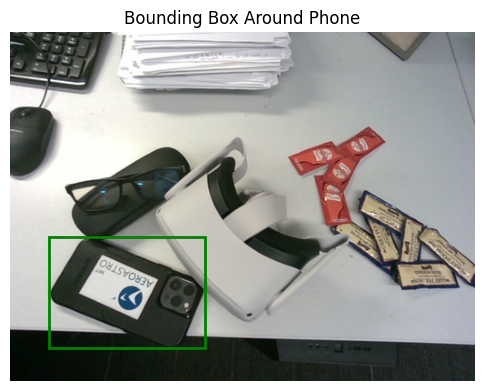

In [ ]:
def call_vlm(prompt):
    print("Connecting to VLM...")
    print(f"Using prompt: '{prompt}' ")

    time.sleep(1)
    return [42, 225, 214, 347]


def display_bbox_on_phone(bbox_cords):
    raw_url = (
        "https://raw.githubusercontent.com/escharf320/6.4210_pset8/master/raw_img.png"
    )
    response = requests.get(raw_url)
    response.raise_for_status()

    img = Image.open(BytesIO(response.content))
    fig, ax = plt.subplots(figsize=(6, 6))

    x0, y0, x1, y1 = bbox_cords

    w, h = x1 - x0, y1 - y0

    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Bounding Box Around Phone")

    plt.show()


prompt = "Return the coordinates for a bounding box around the phone in this image"

bbox_coords = call_vlm(prompt)
print("\n-------------\n")
print(bbox_coords)
print("Copy these coordinates to your clipboard. You will need them in the next cell.")
display_bbox_on_phone(bbox_coords)

# Step 5: Prompt SAM with the Bounding Box

Now that the VLM has located the object (“phone”), we’ll use that **bounding box as a prompt** for SAM.  
SAM will then generate a **precise segmentation mask** for the object inside that box.

#### TODO: Copy the bounding box generated in step 4 into the next cell. 



In [ ]:
def run_sam_bounding_box(bounding_box_coords) -> Image.Image:
    assert (
        bounding_box_coords is not None
    ), "Bounding box coordinates must be provided. Copy them from the cell above"
    try:
        print("Running SAM on input image ...")
        print("Using_bounding_box_prompt. Generating a mask for boxed region")
        time.sleep(1)
        raw_url = sam_prompt = (
            "https://raw.githubusercontent.com/escharf320/6.4210_pset8/master/mask_with_bounding_box_overlay.png"
        )

        response = requests.get(raw_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        return img
    except Exception as e:
        print(f"Error: {e}")
        return None


def display_image(img: Image.Image, title: str = None):
    if img is None:
        print("Failed, no image to display.")
        return

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


# TODO: copy bounding box coords from above
bbox_coords = None
img = run_sam_bounding_box(bbox_coords)
display_image(img, title="Segmentation Mask with Bounding Box Prompting")

AssertionError: Bounding box coordinates must be provided

## Great! Now we have a clear segmentation of the phone that we can use for future manipulation and planning tasks!

# Summary and Takeaways

- SAM sees *everything*,  
- VLM understands *what things are*,  
- Together, they allow systems to *see, understand, and act* based on human language.


